# HDR analysis of a squared exponential process

In this document, we experiment the HDR plot with a squared exponential model. Depending on the number of component kept in the reduced space, we visualize the confidence band when the sample size increases.

Reference:

https://github.com/openturns/openturns/issues/1710

In [1]:
import openturns as ot
import openturns.viewer as otv
import othdrplot as othdr
import pylab as pl
import tqdm
import numpy as np

In [2]:
def draw_grid(grid, figure_size=(6.0, 6.0)):
    """
    Plot a grid of graphics.
    
    This is a workaround in OT1.16 for #1710
    
    Parameters
    ----------
    grid : ot.GridLayout
        The grid.
    figure_size : a sequence(2)
        The width and height of the figure.
    """
    figure = pl.figure(figsize=figure_size)
    nbrows = grid.getNbRows()
    nbcolumns = grid.getNbColumns()
    for i in range(nbrows):
        for j in range(nbcolumns):
            k = 1 + i + j * nbrows
            graph = grid.getGraph(i, j)
            ax = figure.add_subplot(nbrows, nbcolumns, k)
            _ = otv.View(graph, figure=figure, axes=[ax])
    _ = figure.suptitle(grid.getTitle())
    return figure

In [3]:
def draw_band(
    gaussian_process, sample_size=500, alpha_max=0.95, number_of_components=2
):
    """
    Draw a confidence band for a gaussian process.

    Uses the Karhunen-Loève decomposition for dimension reduction.

    Parameters
    ----------
    gaussian_process : ot.GaussianProcess
        A Gaussian process.
    sample_size : int, optional
        The sample size. The default is 500.
    alpha_max : float, optional
        The maximum alpha level for outlier selection. The default is 0.95.
    number_of_components : int, optional
        The number of dimensions in the reduced space. The default is 2.

    Returns
    -------
    graph : ot.Graph
        The confidence band at level alpha_max.
    """
    processSample = gaussian_process.getSample(sample_size)
    # KL decomposition
    reduction = othdr.KarhunenLoeveDimensionReductionAlgorithm(
        processSample, number_of_components
    )
    reduction.run()
    reducedComponents = reduction.getReducedComponents()

    # Distribution fit in reduced space
    ks = ot.KernelSmoothing()
    reducedDistribution = ks.build(reducedComponents)
    # HDR
    hdr = othdr.ProcessHighDensityRegionAlgorithm(
        processSample, reducedComponents, reducedDistribution, [alpha_max]
    )
    hdr.run()
    graph = hdr.draw(drawOutliers=False)
    graph.setLegends([""])
    graph.setTitle(r"Sample size=%d, max. $\alpha$=%.2f" % (sample_size, alpha_max))
    return graph

In [4]:
def draw_region(
    gaussian_process, sample_size=500, alpha_max=0.95, number_of_components=2
):
    """
    Draw a confidence region for a gaussian process in reduced 2D plane.

    Uses the Karhunen-Loève decomposition for dimension reduction.

    Parameters
    ----------
    gaussian_process : ot.GaussianProcess
        A Gaussian process.
    sample_size : int, optional
        The sample size. The default is 500.
    alpha_max : float, optional
        The maximum alpha level for outlier selection. The default is 0.95.
    number_of_components : int, optional
        The number of dimensions in the reduced space. The default is 2.
        The possible values are 1 and 2.

    Returns
    -------
    graph : ot.Graph
        The confidence region at level alpha_max.
    """
    if number_of_components > 2:
        raise ValueError(
            "The number of components is equal to %d which is greater than 2"
            % (number_of_components)
        )
    if number_of_components < 1:
        raise ValueError(
            "The number of components is equal to %d which is lower than 1"
            % (number_of_components)
        )
    processSample = gaussian_process.getSample(sample_size)
    # KL decomposition
    reduction = othdr.KarhunenLoeveDimensionReductionAlgorithm(
        processSample, number_of_components
    )
    reduction.run()
    reducedComponents = reduction.getReducedComponents()

    # Distribution fit in reduced space
    ks = ot.KernelSmoothing()
    reducedDistribution = ks.build(reducedComponents)
    # HDR
    hdr = othdr.HighDensityRegionAlgorithm(
        reducedComponents, reducedDistribution, [alpha_max]
    )
    hdr.run()
    grid = hdr.draw(drawOutliers=True, drawInliers=True)
    if number_of_components == 1:
        graph = grid.getGraph(0, 0)
    else:
        graph = grid.getGraph(1, 0)
    return graph

In [5]:
def SetGraphBoundingBox(graph, xmin=None, xmax=None, ymin=None, ymax=None):
    """
    Set the bounding box in a graph with keywords.

    Parameters
    ----------
    xmin : float
        The x minimum value
    xmax : float
        The x maximum value
    ymin : float
        The y minimum value
    ymax : float
        The y maximum value

    Returns
    -------
    graph : ot.Graph
        The graph with updated bounds.
    """
    boundingBox = graph.getBoundingBox()
    lb = boundingBox.getLowerBound()
    ub = boundingBox.getUpperBound()
    if xmin is not None:
        lb[0] = xmin
    if ymin is not None:
        lb[1] = ymin
    if xmax is not None:
        ub[0] = xmax
    if ymax is not None:
        ub[1] = ymax
    boundingBox.setLowerBound(lb)
    boundingBox.setUpperBound(ub)
    graph.setBoundingBox(boundingBox)
    return graph

## Defined squared exponential covariance model

We consider the $[0, 10]$ interval and define the squared exponential covariance model with standard parameters.

In [6]:
mesher = ot.IntervalMesher([100])
interval = ot.Interval([0.0], [10.0])
timeGrid = mesher.build(interval)

In [7]:
covarianceModel = ot.SquaredExponential()

We generate a sample of the Gaussian process and visualize it:

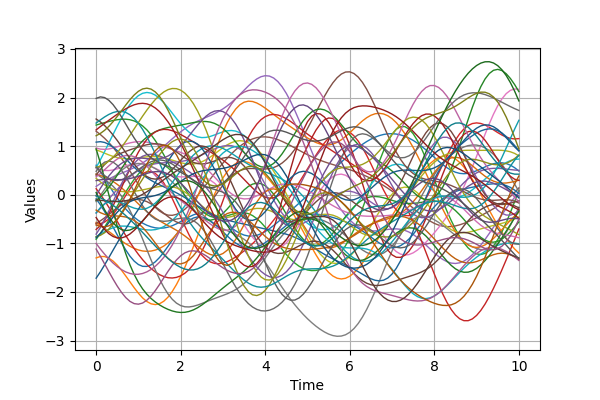

In [8]:
gaussian_process = ot.GaussianProcess(covarianceModel, timeGrid)
sample_size = 50
processSample = gaussian_process.getSample(sample_size)
graph = processSample.drawMarginal(0)
graph.setTitle("")
graph

The curves have the smooth $C^\infty$ regularity that we expected from a squared exponential covariance model. The height of the curves are constrained by the Gaussian process definition: for a given time, the distribution of values in the sample has a Gaussian distribution.

## HDR analysis

To use the HDR we use the Karhunen-Loève decomposition with 2 components and fit a kernel smoothing non parametric distribution on the sample in the reduced space.

In [9]:
# KL decomposition
reduction = othdr.KarhunenLoeveDimensionReductionAlgorithm(processSample, 2)
reduction.run()
reducedComponents = reduction.getReducedComponents()

# Distribution fit in reduced space
ks = ot.KernelSmoothing()
reducedDistribution = ks.build(reducedComponents)

We perform the HDR analysis in the 2D space with maximum $\alpha=0.8$, because the sample has a small size.

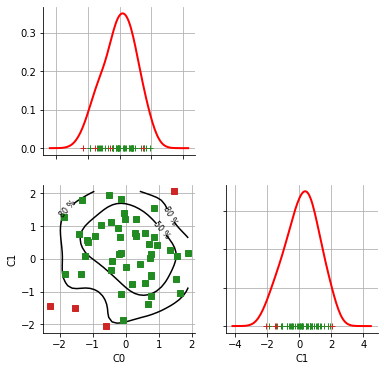

In [10]:
mydp = othdr.HighDensityRegionAlgorithm(
    reducedComponents, reducedDistribution, [0.8, 0.5]
)
mydp.run()
grid = mydp.draw(drawInliers=True)
view = otv.View(grid).getFigure().set_size_inches(6.0, 6.0)

We see that 4 curves are identified as outliers. 

The HDR can also be performed in the physical space.

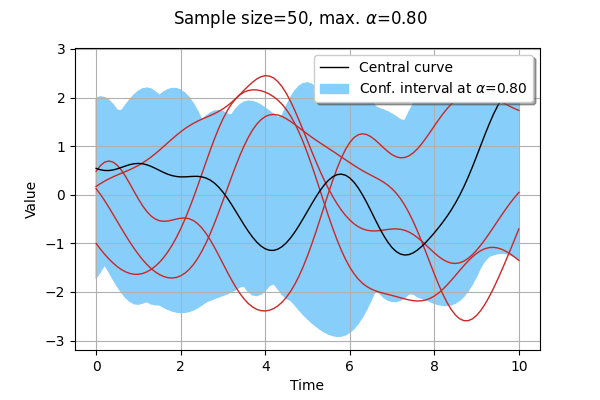

In [11]:
alpha_max = 0.8
hdr = othdr.ProcessHighDensityRegionAlgorithm(
    processSample, reducedComponents, reducedDistribution, [alpha_max, 0.5]
)
hdr.run()
graph = hdr.draw()
graph.setTitle(r"Sample size=%d, max. $\alpha$=%.2f" % (sample_size, alpha_max))
graph.setYTitle("Value")
graph.setXTitle("Time")
graph

The corresponding 4 curves are plot in the physical space.

## Increase the sample size with 2 components

The following loop increases the sample size and plots the HDR in the physical space. We use 2 components in the Karhunen-Loève decomposition.

100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


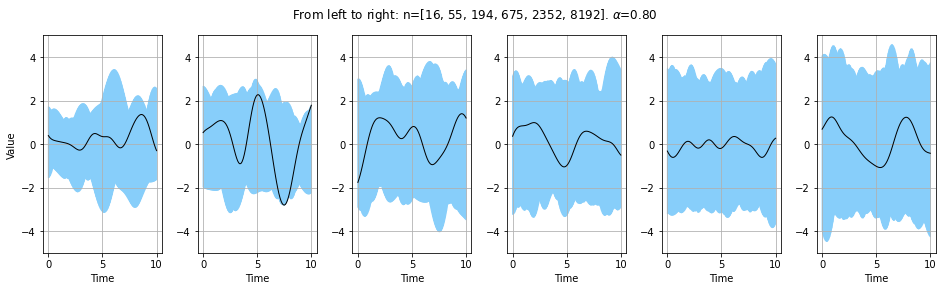

In [12]:
sample_array = [int(i) for i in np.logspace(4, 13, 6, base=2.0)]
grid = ot.GridLayout(1, len(sample_array))
for i in tqdm.tqdm(range(len(sample_array))):
    graph = draw_band(gaussian_process, sample_size=sample_array[i], number_of_components = 2)
    graph = SetGraphBoundingBox(graph, ymin = -5.0, ymax = 5.0)
    if i == 0:
        graph.setYTitle("Value")
    graph.setXTitle("Time")
    grid.setGraph(0, i, graph)
grid.setTitle(r"From left to right: n=%s. $\alpha$=%.2f" % (sample_array, alpha_max))
_ = draw_grid(grid, figure_size = (16.0, 4.0))
pl.subplots_adjust(wspace=0.3)

We see that the confidence band increases vertically converges slowly. 

We then plot the HDR in the reduced space in 2 dimensions. 

100%|██████████| 6/6 [00:10<00:00,  1.78s/it]
/home/devel/Documents/venvOTHDRPlot/lib/python3.8/site-packages/openturns/viewer.py:432: UserWarning: No contour levels were found within the data range.
  contourset = self._ax[0].contour(X, Y, Z, **contour_kw)


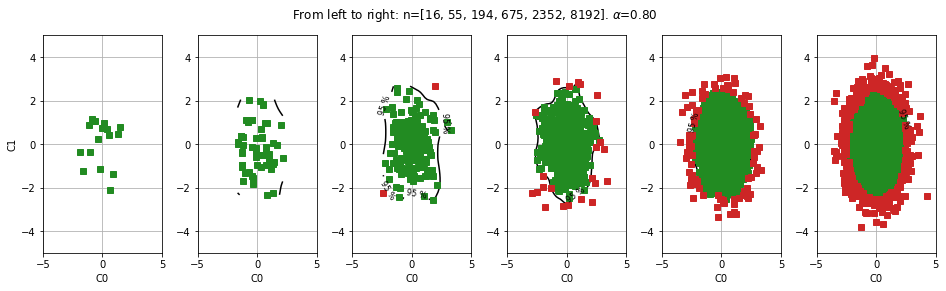

In [13]:
sample_array = [int(i) for i in np.logspace(4, 13, 6, base=2.0)]
grid = ot.GridLayout(1, len(sample_array))
for i in tqdm.tqdm(range(len(sample_array))):
    graph = draw_region(gaussian_process, sample_size=sample_array[i])
    graph = SetGraphBoundingBox(graph, xmin = -5.0, xmax = 5.0, ymin = -5.0, ymax = 5.0)
    if i > 0:
        graph.setYTitle("")
    grid.setGraph(0, i, graph)
grid.setTitle(r"From left to right: n=%s. $\alpha$=%.2f" % (sample_array, alpha_max))
_ = draw_grid(grid, figure_size = (16.0, 4.0))
pl.subplots_adjust(wspace=0.3)

We see that the confidence region at 95% converges when the sample size increases.

## Increase the sample size with 1 component

The following loop increases the sample size and plots the HDR in the physical space. We use 1 components in the Karhunen-Loève decomposition.

100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


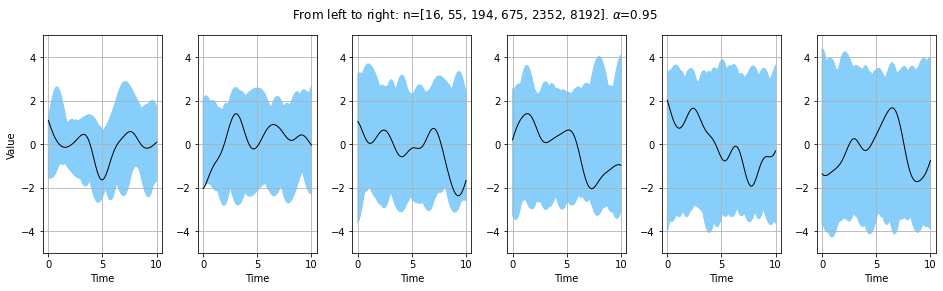

In [14]:
alpha_max = 0.95
sample_array = [int(i) for i in np.logspace(4, 13, 6, base=2.0)]
grid = ot.GridLayout(1, len(sample_array))
for i in tqdm.tqdm(range(len(sample_array))):
    graph = draw_band(gaussian_process, sample_size=sample_array[i], number_of_components = 1, alpha_max=alpha_max)
    graph = SetGraphBoundingBox(graph, ymin = -5.0, ymax = 5.0)
    if i == 0:
        graph.setYTitle("Value")
    graph.setXTitle("Time")
    grid.setGraph(0, i, graph)
grid.setTitle(r"From left to right: n=%s. $\alpha$=%.2f" % (sample_array, alpha_max))
_ = draw_grid(grid, figure_size = (16.0, 4.0))
pl.subplots_adjust(wspace=0.3)

We also see that the confidence band increases and slowly converges. 

100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


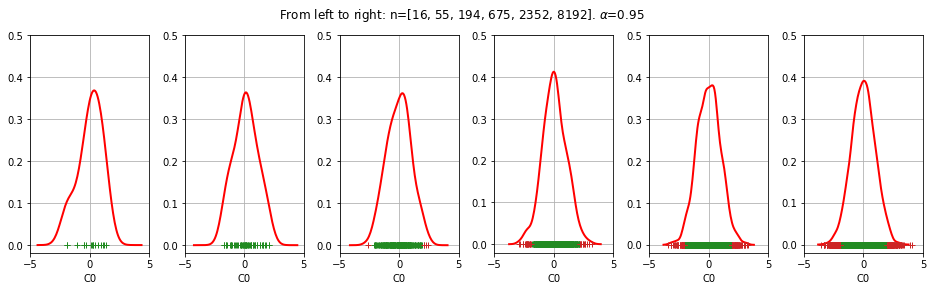

In [15]:
sample_array = [int(i) for i in np.logspace(4, 13, 6, base=2.0)]
grid = ot.GridLayout(1, len(sample_array))
for i in tqdm.tqdm(range(len(sample_array))):
    graph = draw_region(gaussian_process, sample_size=sample_array[i], number_of_components = 1)
    graph = SetGraphBoundingBox(graph, xmin = -5.0, xmax = 5.0, ymax = 0.5)
    if i > 0:
        graph.setYTitle("")
    grid.setGraph(0, i, graph)
grid.setTitle(r"From left to right: n=%s. $\alpha$=%.2f" % (sample_array, alpha_max))
_ = draw_grid(grid, figure_size = (16.0, 4.0))
pl.subplots_adjust(wspace=0.3)

We see that the confidence interval converges in the 1D reduced spaces. This shows that the first coordinate of the projection of the trajectories on the first Karhunen-Loève mode is inside an interval with fixed length. 

In [16]:
sample_array = [int(i) for i in np.logspace(4, 14, 6, base=2.0)]
number_of_components = 1
for i in range(len(sample_array)):
    sample_size=sample_array[i]
    processSample = gaussian_process.getSample(sample_size)
    # KL decomposition
    reduction = othdr.KarhunenLoeveDimensionReductionAlgorithm(
        processSample, number_of_components
    )
    reduction.run()
    reducedComponents = reduction.getReducedComponents()
    # Distribution fit in reduced space
    ks = ot.KernelSmoothing()
    reducedDistribution = ks.build(reducedComponents)
    # HDR
    hdr = othdr.HighDensityRegionAlgorithm(
        reducedComponents, reducedDistribution, [alpha_max]
    )
    hdr.run()
    inlierIndices = hdr.computeIndices(False)
    inliner_sample = reducedComponents[inlierIndices, :]
    sample_min = inliner_sample.getMin()[0]
    sample_max = inliner_sample.getMax()[0]
    print("n = %d, Bounds = [%.3f, %.3f]" % (sample_size, sample_min, sample_max))

n = 16, Bounds = [-2.950, 1.316]
n = 64, Bounds = [-2.123, 1.958]
n = 256, Bounds = [-2.072, 1.989]
n = 1024, Bounds = [-1.902, 2.117]
n = 4096, Bounds = [-2.057, 1.975]
n = 16384, Bounds = [-2.018, 1.971]


This empirically confirms that the interval seem to converge approximately to [-2,2].

## Increase the number of components

We want to analyse the confidence bands when the number of modes increases. 

100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


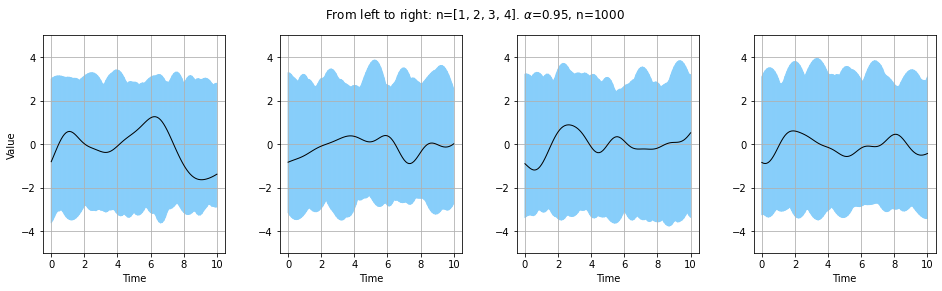

In [17]:
alpha_max = 0.95
sample_size = 1000
component_array = list(range(1, 5))
grid = ot.GridLayout(1, len(component_array))
for i in tqdm.tqdm(range(0, len(component_array))):
    number_of_components = component_array[i]
    graph = draw_band(
        gaussian_process,
        sample_size=sample_size,
        number_of_components=number_of_components,
        alpha_max=alpha_max,
    )
    graph = SetGraphBoundingBox(graph, ymin=-5.0, ymax=5.0)
    if i == 0:
        graph.setYTitle("Value")
    graph.setXTitle("Time")
    grid.setGraph(0, i, graph)
grid.setTitle(r"From left to right: n=%s. $\alpha$=%.2f, n=%d" % (component_array, alpha_max, sample_size))
_ = draw_grid(grid, figure_size=(16.0, 4.0))
pl.subplots_adjust(wspace=0.3)

## Analysis of the modes of the KL decomposition

In [18]:
gaussian_process = ot.GaussianProcess(covarianceModel, timeGrid)
sample_size = 50
processSample = gaussian_process.getSample(sample_size)

In [19]:
threshold = 0.0
algo = ot.KarhunenLoeveSVDAlgorithm(processSample, threshold)
number_of_components = 1
algo.setNbModes(number_of_components)
algo.run()
karhunenLoeveResult = algo.getResult()

In [20]:
collection_KL_mode = karhunenLoeveResult.getModes()

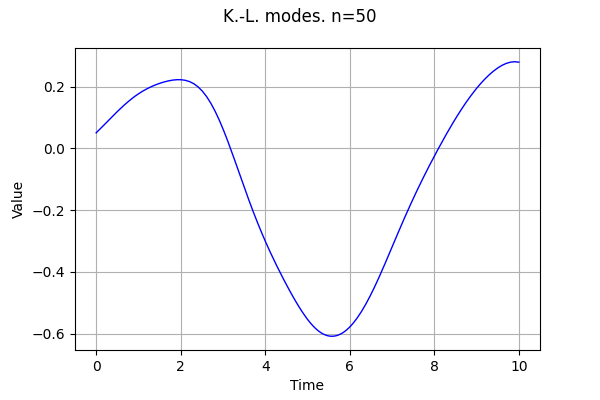

In [21]:
graph = ot.Graph("K.-L. modes. n=%d" % (sample_size), "Time", "Value", True)
for i in range(number_of_components):
    curve = collection_KL_mode[i].draw(0.0, 10.0, 200)
    graph.add(curve)
graph

In [22]:
def draw_KL_modes(gaussian_process, sample_size = 500, number_of_components = 2):
    processSample = gaussian_process.getSample(sample_size)
    threshold = 0.0
    algo = ot.KarhunenLoeveSVDAlgorithm(processSample, threshold)
    algo.setNbModes(number_of_components)
    algo.run()
    karhunenLoeveResult = algo.getResult()
    collection_KL_mode = karhunenLoeveResult.getModes()
    graph = ot.Graph("K.-L. modes. n=%d" % (sample_size), "Time", "Value", True)
    for i in range(number_of_components):
        curve = collection_KL_mode[i].draw(0.0, 10.0, 200)
        curve.setLegends(["#%d" % (i)])
        graph.add(curve)
    graph.setLegendPosition("topright")
    graph.setColors(ot.DrawableImplementation_BuildDefaultPalette(number_of_components))
    return graph

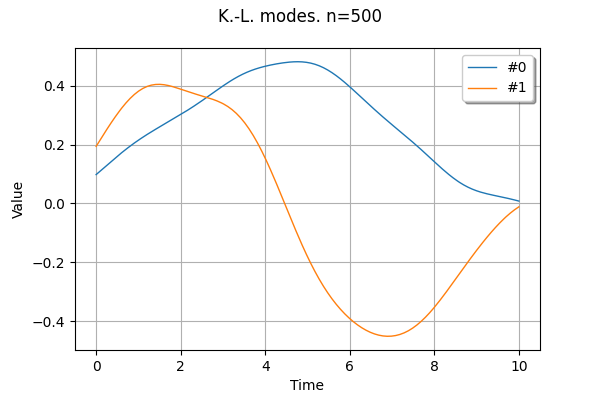

In [23]:
draw_KL_modes(gaussian_process, sample_size = 500, number_of_components = 2)

100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


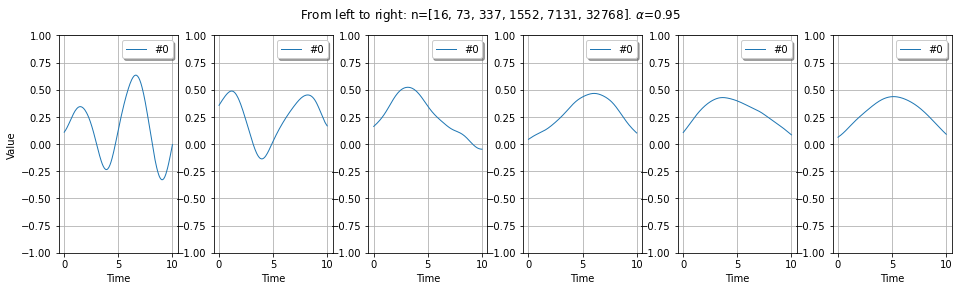

In [24]:
sample_array = [int(i) for i in np.logspace(4, 15, 6, base=2.0)]
grid = ot.GridLayout(1, len(sample_array))
for i in tqdm.tqdm(range(len(sample_array))):
    graph = draw_KL_modes(gaussian_process, sample_size = sample_array[i], number_of_components = 1)
    graph = SetGraphBoundingBox(graph, ymin = -1.0, ymax = 1.0)
    if i > 0:
        graph.setYTitle("")
    grid.setGraph(0, i, graph)
grid.setTitle(r"From left to right: n=%s. $\alpha$=%.2f" % (sample_array, alpha_max))
_ = draw_grid(grid, figure_size = (16.0, 4.0))
pl.subplots_adjust(wspace=0.3)

100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


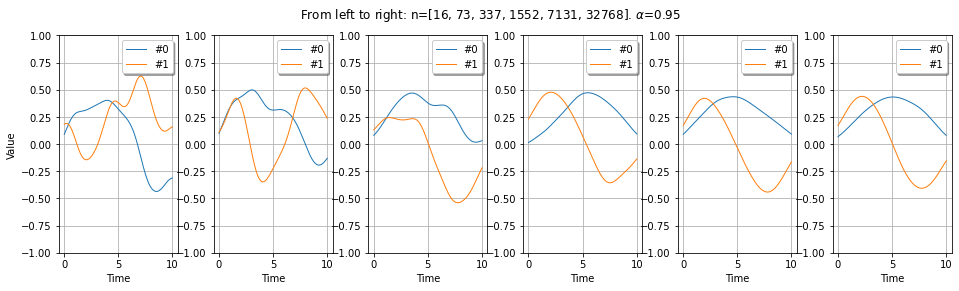

In [25]:
sample_array = [int(i) for i in np.logspace(4, 15, 6, base=2.0)]
grid = ot.GridLayout(1, len(sample_array))
for i in tqdm.tqdm(range(len(sample_array))):
    graph = draw_KL_modes(gaussian_process, sample_size = sample_array[i], number_of_components = 2)
    graph = SetGraphBoundingBox(graph, ymin = -1.0, ymax = 1.0)
    if i > 0:
        graph.setYTitle("")
    grid.setGraph(0, i, graph)
grid.setTitle(r"From left to right: n=%s. $\alpha$=%.2f" % (sample_array, alpha_max))
_ = draw_grid(grid, figure_size = (16.0, 4.0))
pl.subplots_adjust(wspace=0.3)

100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


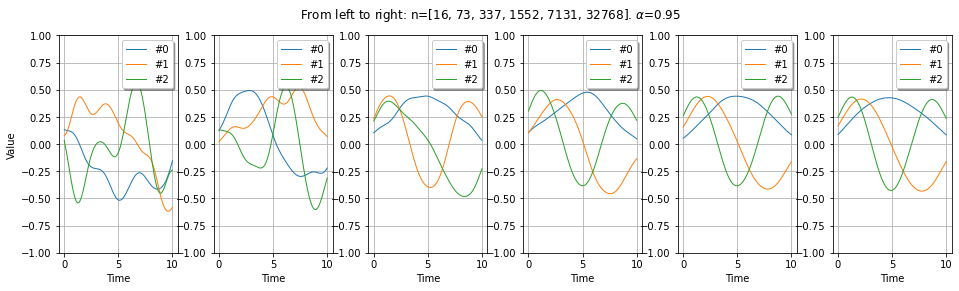

In [26]:
sample_array = [int(i) for i in np.logspace(4, 15, 6, base=2.0)]
grid = ot.GridLayout(1, len(sample_array))
for i in tqdm.tqdm(range(len(sample_array))):
    graph = draw_KL_modes(gaussian_process, sample_size = sample_array[i], number_of_components = 3)
    graph = SetGraphBoundingBox(graph, ymin = -1.0, ymax = 1.0)
    if i > 0:
        graph.setYTitle("")
    grid.setGraph(0, i, graph)
grid.setTitle(r"From left to right: n=%s. $\alpha$=%.2f" % (sample_array, alpha_max))
_ = draw_grid(grid, figure_size = (16.0, 4.0))
pl.subplots_adjust(wspace=0.3)

We see that the K.-L. modes converge when the sample size increases. We see that no less than 500 trajectories are required to compute an approximation of the modes. These modes are increasingly oscillatory. 

It would be interesting to compare these approximated modes to the exact modes, if available.

In [27]:
sample_size = 10000
processSample = gaussian_process.getSample(sample_size)
threshold = 0.0
algo = ot.KarhunenLoeveSVDAlgorithm(processSample, threshold)
algo.setNbModes(10)
algo.run()
karhunenLoeveResult = algo.getResult()
karhunenLoeveResult.getEigenValues()

class=Point name=Unnamed dimension=10 values=[2.41516,2.07794,1.74426,1.34855,0.936852,0.611192,0.369451,0.213229,0.113524,0.0561642]

The first eigenvalue is approximately $\lambda_1 = 2.4$.

## Analysis

Assume that a curve $X(t)$ is decomposed onto the $m$ first mode of the K.-L. decomposition. 
Its decomposition is:
$$
X(t) = \sum_{k=1}^m \xi_k \sqrt{\lambda_k} \varphi_k(t)
$$

for $t \in [t_{min}, t_{max}]$ where $\xi_k \in\mathbb{R}$ is the coefficient, $\lambda_k$ is the eigenvalue and $\varphi_k$ is the mode. 

For any $k=1,...,m$, assume that $\lambda_k$ and $\varphi_k(t)$ are computed. Then the curve $X(t)$ is represented in the reduced space by the vector $(\xi_1,\ldots,\xi_m)^T\in\mathbb{R}^m$. 

For $k=1,...m$, assume that the modes are bounded:
$$
\|\varphi_k(t)\|_\infty < \infty
$$
for any $t \in [t_{min}, t_{max}]$. 
Therefore, if $(\xi_1,\ldots,\xi_m)^T$ is inside a bounded set of $\mathbb{R}^m$, the corresponding value $X(t)$ must also be bounded. 

## Exact confidence band with 1 component and approximate KL decomposition

In [28]:
sample_size = 10000
processSample = gaussian_process.getSample(sample_size)
threshold = 0.0
algo = ot.KarhunenLoeveSVDAlgorithm(processSample, threshold)
algo.setNbModes(1)
algo.run()
karhunenLoeveResult = algo.getResult()

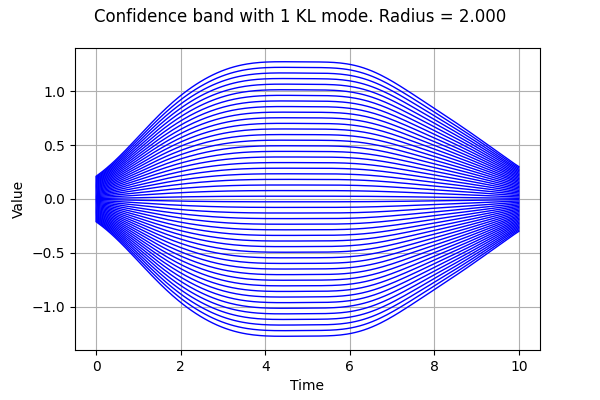

In [29]:
xi_radius = 2.0
graph = ot.Graph("Confidence band with 1 KL mode. Radius = %.3f" % (xi_radius), "Time", "Value", True)
for s in np.linspace(-1.0, 1.0, 50):
    xi_0 = xi_radius * s
    reduced_mode_function = karhunenLoeveResult.lift([xi_0])
    curve = reduced_mode_function.draw(0.0, 10.0, 200)
    graph.add(curve)
graph.setLegendPosition("topright")
graph

This would be the limits of the confidence band if 
* the exact $\xi$ bounds were -2.0 and 2.0,
* each curve in the sample were perfectly represented by one KL mode only. 

## Exact confidence band with 2 components and approximate KL decomposition

In [30]:
sample_size = 10000
processSample = gaussian_process.getSample(sample_size)
threshold = 0.0
algo = ot.KarhunenLoeveSVDAlgorithm(processSample, threshold)
algo.setNbModes(2)
algo.run()
karhunenLoeveResult = algo.getResult()

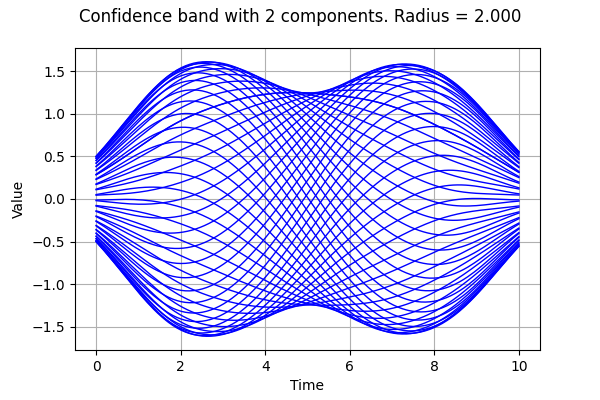

In [31]:
reduced_radius = 2.0
graph = ot.Graph(
    "Confidence band with 2 components. Radius = %.3f" % (reduced_radius),
    "Time",
    "Value",
    True,
)
for omega in np.linspace(0.0, 2.0 * np.pi, 50):
    xi_0 = reduced_radius * np.cos(omega)
    xi_1 = reduced_radius * np.sin(omega)
    reduced_mode_function = karhunenLoeveResult.lift([xi_0, xi_1])
    curve = reduced_mode_function.draw(0.0, 10.0, 200)
    graph.add(curve)
graph.setLegendPosition("topright")
graph

This would be the limits of the confidence band if 
* the exact $\xi$ bounds were -2.0 and 2.0,
* each curve in the sample were perfectly represented by one KL mode only. 